# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

# DATA PROCESS

In [47]:
from utils import ProgressBar
import numpy as np

# 读入所有长度为5以下的中英文句子对

(英文以单词为单位，中文以字符为单位)

读入后enlines = 

```
[['deuces', 'the', 'winner', '.'],
 ['a', 'couple', 'of', 'what', '?'],
 ['a', 'pair', 'of', 'wives', '?'],
 ['husband', 'and', 'wife', '.'],
 ['couple', '.'],
 ....
 ]
 ```

chlines = 

```
[['一', '对', '二', '胜', '。'],
 ['一', '对', '什', '么', '？'],
 ['一', '对', '太', '太', '？'],
 ['一', '对', '夫', '妇', '。'],
 ['一', '对', '夫', '妻', '。'],
 ...
 ]
```

In [48]:
enline = None
chline = None

sentlength = 5

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
with open('data/segmented_train_seg_by_word.txt',encoding='utf=8') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        chlinesp = [i for i in chline.strip("\n").replace(' ','')]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
        

 100.00 % [==================================================>] 10000000/10000000 	 used:63s eta:0 s

## 看一下读入之后的中英文句子对

In [49]:
enlines[:10]

[['deuces', 'the', 'winner', '.'],
 ['a', 'couple', 'of', 'what', '?'],
 ['a', 'pair', 'of', 'wives', '?'],
 ['husband', 'and', 'wife', '.'],
 ['couple', '.'],
 ['nice', 'couple', '.'],
 ['two', 'lovers', '.'],
 ['a', 'couple', 'getting', 'married', '.'],
 ['couple', 'of', 'newbies', '?'],
 ['a', 'couple', 'of', 'gunslingers', '.']]

In [50]:
chlines[:10]

[['一', '对', '二', '胜', '。'],
 ['一', '对', '什', '么', '？'],
 ['一', '对', '太', '太', '？'],
 ['一', '对', '夫', '妇', '。'],
 ['一', '对', '夫', '妻', '。'],
 ['一', '对', '好', '人', '。'],
 ['一', '对', '情', '人', '。'],
 ['一', '对', '新', '人', '。'],
 ['一', '对', '新', '手', '？'],
 ['一', '对', '枪', '手', '。']]

## 中英文句子对一共有10W对左右

In [52]:
len(chlines),len(enlines)

(103912, 103912)

# 构建中英文词表

In [53]:
enwords = []
chwords = []
for sent in enlines:
    for enword in sent:
        enwords.append(enword)
        
for sent in chlines:
    for chword in sent:
        chwords.append(chword)
    

In [56]:
len(chwords)

496885

In [57]:
from collections import Counter

## 我们还是使用Counter来统计中英文中最常见的一些单词

In [58]:
Counter(enwords).most_common(10)

[('.', 49461),
 ('?', 14511),
 ('the', 10472),
 ('i', 10013),
 (',', 9489),
 ('!', 8807),
 ('you', 7493),
 ('a', 6860),
 ("'", 5555),
 ('it', 5524)]

In [59]:
Counter(chwords).most_common(10)

[('。', 44900),
 ('我', 15087),
 ('？', 14454),
 ('你', 9087),
 ('！', 8915),
 ('了', 8663),
 ('的', 8053),
 ('，', 7291),
 ('一', 6091),
 ('是', 5946)]

## 查看英文单词和中文单词数量（构建词表前,去重后）

In [60]:
len(set(enwords)),len(set(chwords))

(21739, 4054)

# 构建词表

In [11]:
ch2ind = {}
ind2ch = {}

en2ind = {}
ind2en = {}

# 将四个特殊符号让入词表

In [46]:
specialchars = ['<eos>','<start>','<end>','<unk>']

In [61]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

In [62]:
for one in specialchars:
    addchar(ch2ind,ind2ch,one)
    addchar(en2ind,ind2en,one)

# 将中英文常见单词分别放入中英文词表

In [63]:
for word,_ in Counter(enwords).most_common(10000):
    addchar(en2ind,ind2en,word)

In [64]:
for word,_ in Counter(chwords).most_common(10000):
    addchar(ch2ind,ind2ch,word)

# 中英文词表长度

In [66]:
len(en2ind),len(ch2ind)

(10004, 4058)

# 构建模型输入数据

In [68]:
# 一共有5个输入数据的数组，思考一下：这些输入数据分别对应了ppt里的哪些位置？

dat_x_in = []
dat_y_in = []
dat_y_out = []

dat_x_len = []
dat_y_len = []

for ensent in enlines:
    indsent = [en2ind.get(i,en2ind['<unk>']) for i in ensent]
    indsent.append(en2ind['<eos>'])
    dat_x_in.append(indsent)
    dat_x_len.append(len(indsent))
    
# 为什么句号不能代表eos呢？
for chsent in chlines:
    indsent = [ch2ind.get(i,ch2ind['<unk>']) for i in chsent]
    #indsent.append(ch2ind['<eos>'])
    dat_y_in.append([ch2ind['<start>']] + indsent)
    dat_y_out.append(indsent + [ch2ind['<end>']])
    dat_y_len.append(len(indsent) + 1)

### 一个dat_x_in的数据

In [69]:
[ind2en[i] for i in dat_x_in[4]]

['couple', '.', '<eos>']

### 一个dat_y_in的数据

In [70]:
[ind2ch[i] for i in dat_y_in[4]]

['<start>', '一', '对', '夫', '妻', '。']

### 一个dat_y_out的数据

In [71]:
[ind2ch[i] for i in dat_y_out[4]]

['一', '对', '夫', '妻', '。', '<end>']

### 与其相对应的两个length

In [72]:
dat_x_len[4],dat_y_len[4]

(3, 6)

In [73]:
len(dat_x_in),\
len(dat_y_in),\
len(dat_y_out),\
len(dat_x_len),\
len(dat_y_len)

(103912, 103912, 103912, 103912, 103912)

# MODEL PART

In [74]:
from tensorflow.python.layers import core as layers_core

In [75]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


In [27]:
embedding_size = 512
num_units = 512
batch_size = 128
layer_number = 2
max_grad = 1.0
dropout = 0.2
src_vocab_size = len(en2ind)
target_vocat_size = len(ch2ind)
seq_max_len = sentlength + 1
maximum_iterations = 10

In [76]:

tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

with tf.device('/gpu:1'):
    initializer = tf.random_uniform_initializer(
        -0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    
    # 画个图展示各个输入在模型中的位置和具体形状
    x = tf.placeholder("int32", [None, None])
    y = tf.placeholder("int32", [None, None])
    y_in = tf.placeholder("int32",[None,None])
    
    x_len = tf.placeholder("int32",[None])
    y_len = tf.placeholder("int32",[None])
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # embedding
    embedding_encoder = tf.get_variable(
        "embedding_encoder", [src_vocab_size, embedding_size],dtype=tf.float32)
    embedding_decoder = tf.get_variable(
        "embedding_decoder", [target_vocat_size, embedding_size],dtype=tf.float32)
    
    encoder_emb_inp = tf.nn.embedding_lookup(
        embedding_encoder, x)
    decoder_emb_inp = tf.nn.embedding_lookup(
        embedding_decoder, y_in)
    
    # Build RNN cell
    encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)

    # Run Dynamic RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False,dtype=tf.float32)
        
    
    
    batch_size_in = tf.shape(x)[0]
    projection_layer = layers_core.Dense(
        len(ch2ind), use_bias=False)
    # Dynamic decoding
    # training
    with tf.variable_scope("decode_layer"):
        # Build RNN cell
        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        # Helper
        helper = tf.contrib.seq2seq.TrainingHelper(
            decoder_emb_inp, y_len, time_major=False)
        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, encoder_state,
            output_layer=projection_layer)
        # Dynamic decoding
        outputs, _ , __ = tf.contrib.seq2seq.dynamic_decode(decoder)
        logits = outputs.rnn_output
        target_weights = tf.sequence_mask(
            y_len, seq_max_len, dtype=logits.dtype)
    
    # predicting
    # Helper
    with tf.variable_scope("decode_layer", reuse=True):
        # Helper
        helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embedding_decoder,
            tf.fill([batch_size_in], ch2ind['<start>']), ch2ind['<end>'])

        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, encoder_state,
            output_layer=projection_layer)
        # Dynamic decoding
        outputs, _ , __= tf.contrib.seq2seq.dynamic_decode(
            decoder, maximum_iterations=maximum_iterations)
        translations = outputs.sample_id
        

    # calculate loss
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    train_loss = (tf.reduce_sum(crossent * target_weights) /
        tf.cast(batch_size_in,tf.float32))
    
    optimizer_ori = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    trainable_params = tf.trainable_variables()
    gradients = tf.gradients(train_loss, trainable_params)
    clip_gradients, _ = tf.clip_by_global_norm(gradients, max_grad)
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = optimizer_ori.apply_gradients(
            zip(clip_gradients, trainable_params), global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(train_loss)
    #trainop = tflearn.TrainOp(loss=train_loss, optimizer=optimizer,
    #                          metric=train_loss, batch_size=64)

In [77]:
session.run(tf.global_variables_initializer())

## 思考：encoder中的embedding输出的形状是什么样的？

In [78]:
session.run(encoder_emb_inp,feed_dict={
    x:np.asarray(dat_x_in[:1])
}).shape

(1, 5, 512)

# 按照ppt里说的将各个序列长度使用特殊符号pad到一样长

In [79]:
dat_x_in = tf.keras.preprocessing.sequence.pad_sequences(dat_x_in,padding='post',value=en2ind['<eos>'])
dat_y_in = tf.keras.preprocessing.sequence.pad_sequences(dat_y_in,padding='post',value=en2ind['<end>'])
dat_y_out = tf.keras.preprocessing.sequence.pad_sequences(dat_y_out,padding='post',value=en2ind['<end>'])

dat_x_len = np.asarray(dat_x_len)
dat_y_len = np.asarray(dat_y_len)

In [80]:
dat_x_in.shape,dat_y_in.shape,dat_y_out.shape,dat_x_len.shape,dat_y_len.shape

((103912, 6), (103912, 6), (103912, 6), (103912,), (103912,))

# 训练模型，跑40个epoch

In [81]:
losses = []
beginning_lr = 4
for one_epoch in range(0,40):
    index = np.asarray(list(range(len(dat_x_in))))
    np.random.shuffle(index)
    pb = ProgressBar(worksum=len(index))
    pb.startjob()
    for i in range(0,len(index),batch_size):
        batchindex = index[i:i + batch_size]
        
        batch_lr = beginning_lr if one_epoch < 20 else beginning_lr * 0.5 ** (one_epoch - 20)
        if len(batchindex) < batch_size:
            break
        _,batch_loss = session.run([optimizer,train_loss],feed_dict={
            x:dat_x_in[batchindex],
            y:dat_y_out[batchindex],
            y_in:dat_y_in[batchindex],

            x_len:dat_x_len[batchindex],
            y_len:dat_y_len[batchindex],
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch + 1,i // batch_size,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)

EPOCH 12 batch 447 lr 4 loss 3.0636861324310303 55.19 % [===========================>-----------------------] 57344/103912 	 used:7s eta:6 s

KeyboardInterrupt: 

In [34]:
import pandas as pd

# 查看loss收敛情况

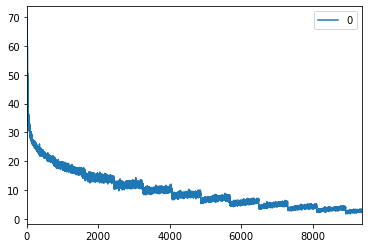

In [82]:
%matplotlib inline
pd.DataFrame(losses).plot()

# run predict

In [83]:
def translate(sent):
    senttoken = [en2ind[i.lower()] for i in sent.split()]
    senttoken.append(en2ind['<eos>'])
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    #print(inputx,inputx_len)
    batch_translations = session.run(translations,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    return ''.join([ind2ch[i] for i in batch_translations])

In [86]:
source_sentence = "you are cool ."

In [87]:
translate(source_sentence)

'你很酷。<end>'

# 存储模型

In [39]:
! mkdir models

mkdir: cannot create directory 'models': File exists


In [40]:
saver = tf.train.Saver()

In [41]:
saver.save(session,'models/seq2seq_model')

'models/seq2seq_model'

In [42]:
! ls -l 'models/seq2seq_model.data-00000-of-00001'

-rw-r--r-- 1 root root 53903364 Dec 11 22:52 models/seq2seq_model.data-00000-of-00001
